# Solving orbital equations with different algorithms

This notebook was adapted from `Orbit_games.ipynb`.



We consider energy plots and orbital solutions in polar coordinates for the general potential energy

$\begin{align}
   U(r) = k r^n
\end{align}$

for different ODE solution algorithms.  The `solve_ivp` function can itself be specified to use different solution methods (with the `method` keyword).  Here we will set it by default to use 'RK23', which is a variant on the Runge-Kutta second-order algorithm.  Second-order in this context means that the accuracy of a calculation will improve by a factor of $10^2 = 100$ if $\Delta t$ is reduced by a factor of ten. 

We will compare it with the crudest algorithm, Euler's method, which is first order, and a second-order algorithm called Leapfrog, which is designed to be precisely <em>time-reversal invariant</em>.  This property guarantees conservation of energy, which is not true of the other algorithms we will consider.

To solve the differential equations for orbits, we have defined the $\mathbf{y}$ 
and $d\mathbf{y}/dt$ vectors as

$\begin{align}
  \mathbf{y} = \left(\begin{array}{c} r(t) \\ \dot r(t) \\ \phi(t)  \end{array} \right) 
  \qquad
  \frac{d\mathbf{y}}{dt} 
       = \left(\begin{array}{c} \dot r(t) \\ \ddot r(t) \\ \dot\phi(t) \end{array} \right) 
       = \left(\begin{array}{c} \dot r(t) \\ 
                                 -\frac{1}{\mu}\frac{dU_{\rm eff}(r)}{dr} \\ 
                                 \frac{l}{\mu r^2} \end{array} \right) 
\end{align}$

where we have substituted the differential equations for $\ddot r$ and $\dot\phi$.

Then Euler's method can be written as a simple prescription to obtain $\mathbf{y}_{i+1}$ 
from $\mathbf{y}_i$, where the subscripts label the elements of the `t_pts` array: 
$\mathbf{y}_{i+1} = \mathbf{y}_i + \left(d\mathbf{y}/dt\right)_i \Delta t$, or, by components:

$\begin{align}
   r_{i+1} &= r_i + \frac{d\mathbf{y}_i[0]}{dt}  \Delta t  \\
   \dot r_{i+1} &= \dot r_{i} + \frac{d\mathbf{y}_i[1]}{dt}  \Delta t \\
   \phi_{i+1} &= \phi_i + \frac{d\mathbf{y}_i[2]}{dt} \Delta t
\end{align}$

**Look at the** `solve_ode_Euler` **method below and verify the algorithm is correctly implemented.** 

The leapfrog method does better by evaluating $\dot r$ at a halfway time step before and after the $r$ evaluation, 
which is both more accurate and incorporates time reversal: 

$\begin{align}
   \dot r_{i+1/2} &= \dot r_{i} + \frac{d\mathbf{y}_i[1]}{dt}  \Delta t/2 \\
   r_{i+1} &= r_i +  \dot r_{i+1/2}  \Delta t  \\
   \dot r_{i+1} &= \dot r_{i+1/2} + \frac{d\mathbf{y}_{i+1}[1]}{dt}  \Delta t/2 \\
   \phi_{i+1} &= \phi_i + \frac{d\mathbf{y}_i[2]}{dt} \Delta t
\end{align}$

**Look at the** `solve_ode_Leapfrog` **method below and verify the algorithm is correctly implemented.** 

A third method is the second-order Runge-Kutta algorithm, which we invoke from `solve_ivp` as `RK23`. 
It does not use a fixed time-step as in our "homemade" implementations, so there is not a direct 
comparison, but we can still check if it conserves energy.

**Run the notebook.  You are to turn in and comment on the "Change in energy with time" plot at the end.  
Where do you see energy conserved or not conserved?  Show that Euler is first order and leapfrog is second 
order by changing $\Delta t$; describe what you did and what you found.**

**Try another potential to see if you get the same general conclusions.**

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

In [2]:
# Change the common font size
font_size = 14
plt.rcParams.update({'font.size': font_size})

In [33]:
class GravitationalOrbits():
    
    def __init__(self, m_1 = 1., m_2 = 1., G = 1.):
        self.m1 = m_1
        self.m2 = m_2
        self.G = G
        
    def dz_dt(self, t, z):
        r_12 = np.sqrt( (z[0]-z[4])**2 + (z[2] -z[6])**2 )
        
        return [z[1], self.G*self.m2* (z[4]-z[0]) / r_12**3, z[3], self.G*self.m2* (z[6] - z[2]) /r_12**3, z[5], -self.G *self.m1* (z[4] - z[0]) / r_12**3, z[7], -self.G*self.m1 * (z[6] - z[2]) /r_12**3 ]
    
    def solve_ode(self, t_pts, z_0, abserr = 1.0e-8, relerr = 1.0e-8):
        
        solution = solve_ivp(self.dz_dt, (t_pts[0], t_pts[-1]), z_0, t_eval = t_pts,
                            method ='RK23', atol = abserr, rtol =relerr)
        x_1, x_dot_1, y_1, y_dot_1, x_2, x_dot_2, y_2, y_dot_2 = solution.y
        
        return x_1, x_dot_1, y_1, y_dot_1, x_2, x_dot_2, y_2, y_dot_2
    
    def solve_ode_Leapfrog(self, t_pts, z_0):
        
        delta_t = t_pts[1] - t_pts[0]
        
        x_1_0, x_dot_1_0, y_1_0, y_dot_1_0, x_2_0, x_dot_2_0, y_2_0, y_dot_2_0 = z_0
        
        num = len(t_pts)
        
        x_1 = np.zeros(num)
        x_dot_1 = np.zeros(num)
        x_dot_1_half = np.zeros(num)
        
        y_1 = np.zeros(num)
        y_dot_1 = np.zeros(num)
        y_dot_1_half = np.zeros(num)
        
        x_2 = np.zeros(num)
        x_dot_2 = np.zeros(num)
        x_dot_2_half = np.zeros(num)
        
        y_2 = np.zeros(num)
        y_dot_2 = np.zeros(num)
        y_dot_2_half = np.zeros(num)
        
        x_1[0] = x_1_0
        x_dot_1[0] = x_dot_1_0
        
        y_1[0] = y_1_0
        y_dot_1[0] = y_dot_1_0
        
        x_2[0] = x_2_0
        x_dot_2[0] = x_dot_2_0
        
        y_2[0] = y_2_0
        y_dot_2[0] = y_dot_2_0
        
        for i in np.arange(num - 1):
            
            t = t_pts[i]
            
            z = [x_1[i], x_dot_1[i], y_1[i], y_dot_1[i], x_2[i], x_dot_2[i], y_2[i], y_dot_2[i]]
            out = self.dz_dt(t, z)
            
            x_dot_1_half[i] = x_dot_1[i] + out[1] * delta_t/2.
            x_1[i + 1] = x_1[i] + x_dot_1_half[i] * delta_t
            
            y_dot_1_half[i] = y_dot_1[i] + out[3] * delta_t/2.
            y_1[i+1] = y_1[i] + y_dot_1_half[i] *delta_t
            
            x_dot_2_half[i] = x_dot_2[i] + out[5] * delta_t/2.
            x_2[i+1] = x_2[i] + x_dot_2_half[i] * delta_t
            
            y_dot_2_half[i] = y_dot_2[i] + out[7] + delta_t/2.
            y_2[i+1] = y_2[i] + y_dot_2_half[i] * delta_t
            
            z = [x_1[i+1], x_dot_1[i], y_1[i+1], y_dot_1[i], x_2[i+1], x_dot_2[i], y_2[i+1], y_dot_2[i]]
            
            out = self.dz_dt(t, z)
            
            x_dot_1[i+1] = x_dot_1_half[i] + out[1] * delta_t/2.
            y_dot_1[i+1] = y_dot_1_half[i] + out[3] * delta_t/2.
            x_dot_2[i+1] = x_dot_2_half[i] + out[5] * delta_t/2.
            y_dot_2[i+1] = y_dot_2_half[i] + out[7] * delta_t/2.
        
        return x_1, x_dot_1, y_1, y_dot_1, x_2, x_dot_2, y_2, y_dot_2
     
    def solve_ode_Leapfrog_n(self, t_pts, z_0):
        
        delta_t = t_pts[1] - t_pts[0]
        
        num = len(t_pts)
        
        n_tot = len(z_0)
        
        z = np.zeros( shape = (n_tot, num))
        dot_half = np.zeros( int(n_tot/2))
        z[:, 0] = z_0
        
        for i in np.arange(num - 1):
            t = t_pts[i]
            z_now = z[:,i]
            out = np.asarray(self.dz_dt(t, z_now))
            
            dot_half = z_now[1::2] + out[1::2]* delta_t/2.
            z[0::2, i+1] = z_now[0::2] + dot_half * delta_t
            
            z_now[0::2] = z[0::2, i+1]
            out = np.asarray(self.dz_dt(t, z_now))
            z[1::2, i+1] = dot_half + out[1::2] * delta_t/2.
            
        return z
            
        
        

In [34]:
def plot_y_vs_x(x, y, axis_labels=None, label=None, title=None, 
                color=None, linestyle=None, semilogy=False, loglog=False,
                ax=None):
    """
    Generic plotting function: return a figure axis with a plot of y vs. x,
    with line color and style, title, axis labels, and line label
    """
    if ax is None:        # if the axis object doesn't exist, make one
        ax = plt.gca()

    if (semilogy):
        line, = ax.semilogy(x, y, label=label, 
                            color=color, linestyle=linestyle)
    elif (loglog):
        line, = ax.loglog(x, y, label=label, 
                          color=color, linestyle=linestyle)
    else:
        line, = ax.plot(x, y, label=label, 
                    color=color, linestyle=linestyle)

    if label is not None:    # if a label if passed, show the legend
        ax.legend()
    if title is not None:    # set a title if one if passed
        ax.set_title(title)
    if axis_labels is not None:  # set x-axis and y-axis labels if passed  
        ax.set_xlabel(axis_labels[0])
        ax.set_ylabel(axis_labels[1])

    return ax, line

In [35]:
def start_stop_indices(t_pts, plot_start, plot_stop):
    start_index = (np.fabs(t_pts-plot_start)).argmin()  # index in t_pts array 
    stop_index = (np.fabs(t_pts-plot_stop)).argmin()  # index in t_pts array 
    return start_index, stop_index

In [36]:
orbit_label = (r'$x$', r'$y$')

t_start = 0.
t_end = 20.
delta_t = 0.001

t_pts = np.arange(t_start, t_end+ delta_t, delta_t)



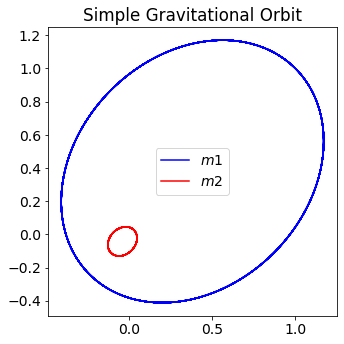

In [37]:
t_start = 0.
t_end = 20.
delta_t = 0.001

G = 1.
m1 = 1.
m2 = 9.

#Looked up the difference between sun & earth mass

o1 = GravitationalOrbits(m1, m2, G)

x_1_0, x_dot_1_0 = 1., -1.
y_1_0, y_dot_1_0 = 1., 1.
x_2_0, x_dot_2_0 = -(m1/m2) * x_1_0, -(m1/m2) * x_dot_1_0
y_2_0, y_dot_2_0 = -(m1/m2) * y_1_0, -(m1/m2) * y_dot_1_0

z_0 = [x_1_0, x_dot_1_0, y_1_0, y_dot_1_0, x_2_0, x_dot_2_0, y_2_0, y_dot_2_0]

x_1, x_dot_1, y_1, y_dot_1, x_2, x_dot_2, y_2, y_dot_2 = o1.solve_ode(t_pts, z_0)

fig = plt.figure(figsize=(5, 5))

ax = fig.add_subplot(1, 1, 1)

start, stop = start_stop_indices(t_pts, t_start, t_end)
ax.plot(x_1, y_1, color = 'blue', label = r'$m1$')
ax.plot(x_2, y_2, color = 'red', label = r'$m2$')
ax.set_title('Simple Gravitational Orbit')
ax.legend()
#ax.set_xlim(-np.max(x_2), np.max(x_2))
ax.set_aspect(1)

fig.tight_layout()
fig.savefig('Simple_orbits.png', bbox_inches = 'tight')


m2 is a larger mass than m1.
m2 represents the Sun while m1 represents the Earth

The Sun orbits in a little circle while the Earth is seen to be orbiting completely around the Sun

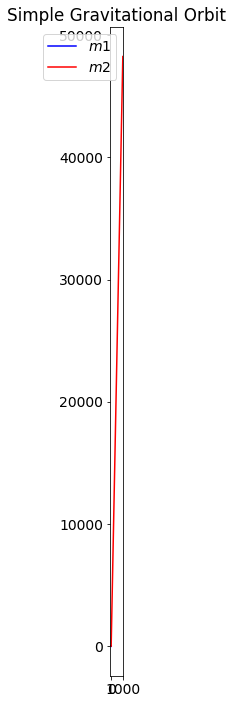

In [39]:
t_start = 0.
t_end = 20.
delta_t = 0.001

G = 20.
m1 = 20.
m2 = 1.

#Looked up the difference between sun & earth mass

o1 = GravitationalOrbits(m1, m2, G)

x_1_0, x_dot_1_0 = 0.1, 0.
y_1_0, y_dot_1_0 = 0., .75
x_2_0, x_dot_2_0 = -(m1/m2) * x_1_0, -(m1/m2) * x_dot_1_0
y_2_0, y_dot_2_0 = -(m1/m2) * y_1_0, -(m1/m2) * y_dot_1_0

z_0 = [x_1_0, x_dot_1_0, y_1_0, y_dot_1_0, x_2_0, x_dot_2_0, y_2_0, y_dot_2_0]

x_1, x_dot_1, y_1, y_dot_1, x_2, x_dot_2, y_2, y_dot_2 = o1.solve_ode_Leapfrog(t_pts, z_0)

fig = plt.figure(figsize=(10, 10))

ax = fig.add_subplot(1, 1, 1)

start, stop = start_stop_indices(t_pts, t_start, t_end)
ax.plot(x_1, y_1, color = 'blue', label = r'$m1$')
ax.plot(x_2, y_2, color = 'red', label = r'$m2$')
ax.set_title('Simple Gravitational Orbit')
ax.legend()
#ax.set_xlim(-np.max(x_2), np.max(x_2))
ax.set_aspect(1)

fig.tight_layout()
fig.savefig('Simple_orbits.png', bbox_inches = 'tight')

#The Leapfrog axes are off, and I do not know how to fix it
